In [9]:
from __future__ import print_function

import argparse
import csv
import os
#from selectors import EpollSelector

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
#from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from utils_c import load_txt
from torch.utils.data import Subset, ConcatDataset, ChainDataset

import time

import models
from utils import progress_bar
from dataset import CIFAR10C, CIFAR100C

%matplotlib inline



In [2]:

my_data_root = 'C:/Users/naama-alon/data'

use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

#if args.seed != 0:
#    torch.manual_seed(args.seed)

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

print('Chose CIFAR10 Corrupted Dataset..')
num_classes=10
corruptions = load_txt('./corruptions.txt')

for i, cname in enumerate(corruptions):
    tmp_dataset = CIFAR10C(root=os.path.join(my_data_root, 'CIFAR-10-C'),name=cname,
                                transform=transform_train)
    start= 20000
    stop = 30000
    indices = [i for i in range(start, stop)] # use sevirity 3
    sev3 = Subset(tmp_dataset, indices)
    split_lengths = [int(len(sev3)*0.833), int(len(sev3)*0.167)]
    sev3_trainset, sev3_testset = random_split(sev3, split_lengths)
    if i==0:
        trainset_arr =  [sev3_trainset]
        testset_arr = [sev3_testset]
    else:
        trainset_arr.append(sev3_trainset)
        testset_arr.append(sev3_testset)

trainset =  ConcatDataset(trainset_arr)
testset =  ConcatDataset(testset_arr)

trainloader = torch.utils.data.DataLoader(trainset,
                                        batch_size=128,
                                        shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                        shuffle=False, num_workers=8)
 

==> Preparing data..
Chose CIFAR10 Corrupted Dataset..


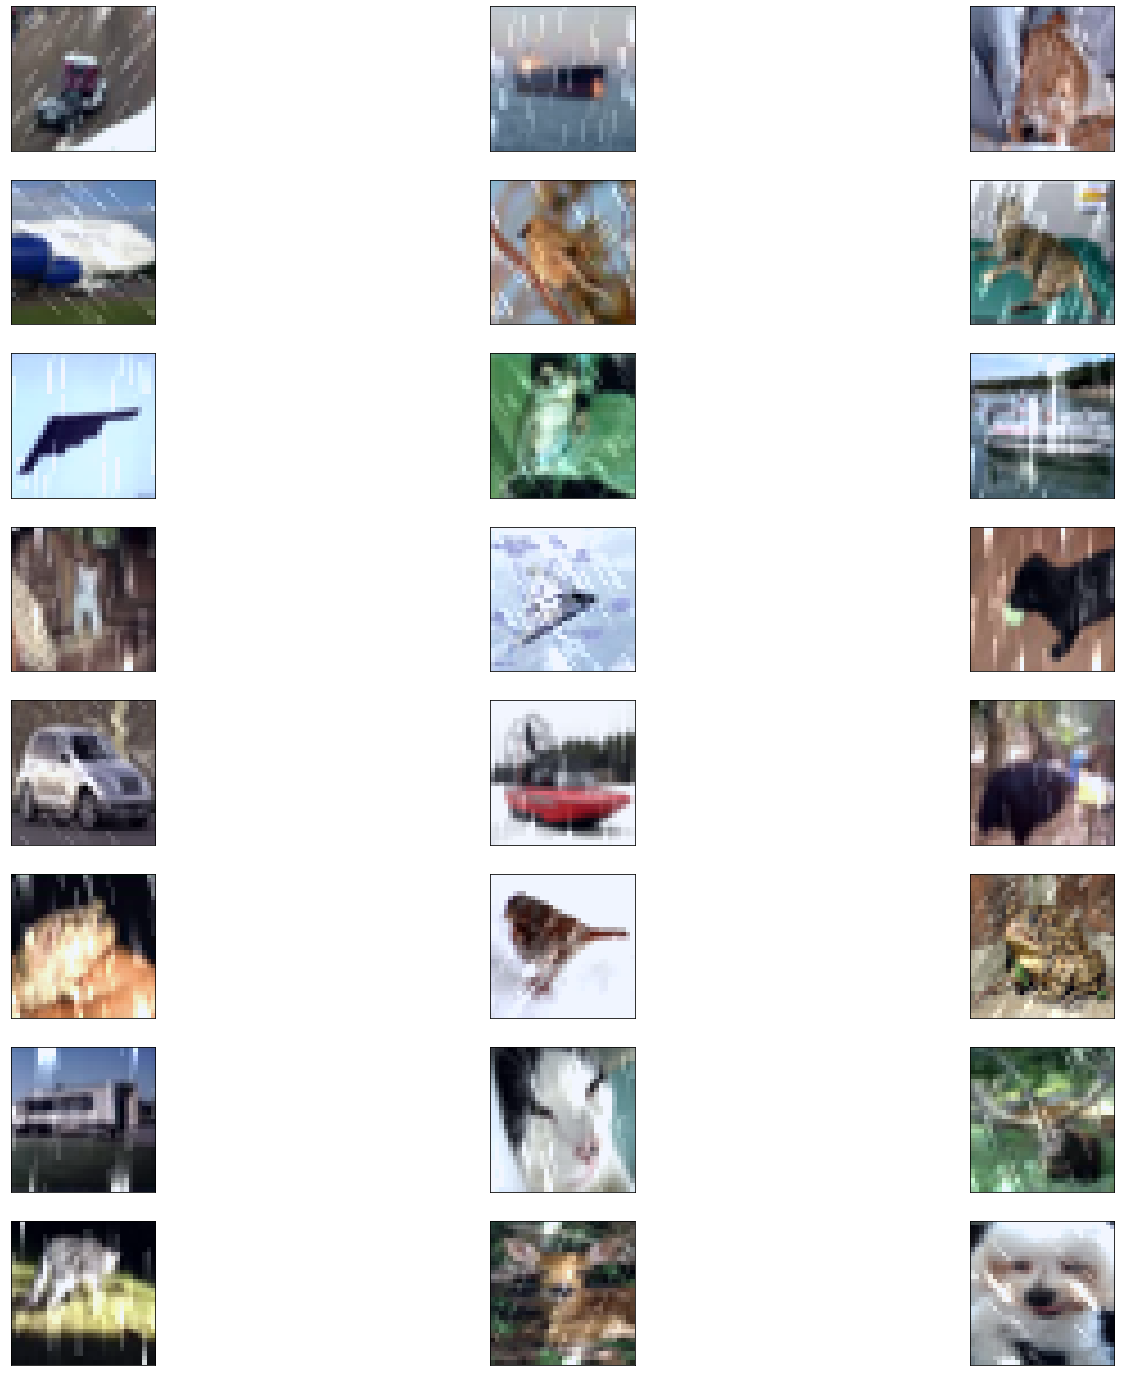

In [19]:
import cs236781.plot as plot
_ = plot.dataset_first_n(trainset, 24, figsize=(25, 25), nrows=8)
#_ = plot.dataset_first_n(trainset, 9, figsize=(15, 10), nrows=3)

(<Figure size 1800x1800 with 24 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

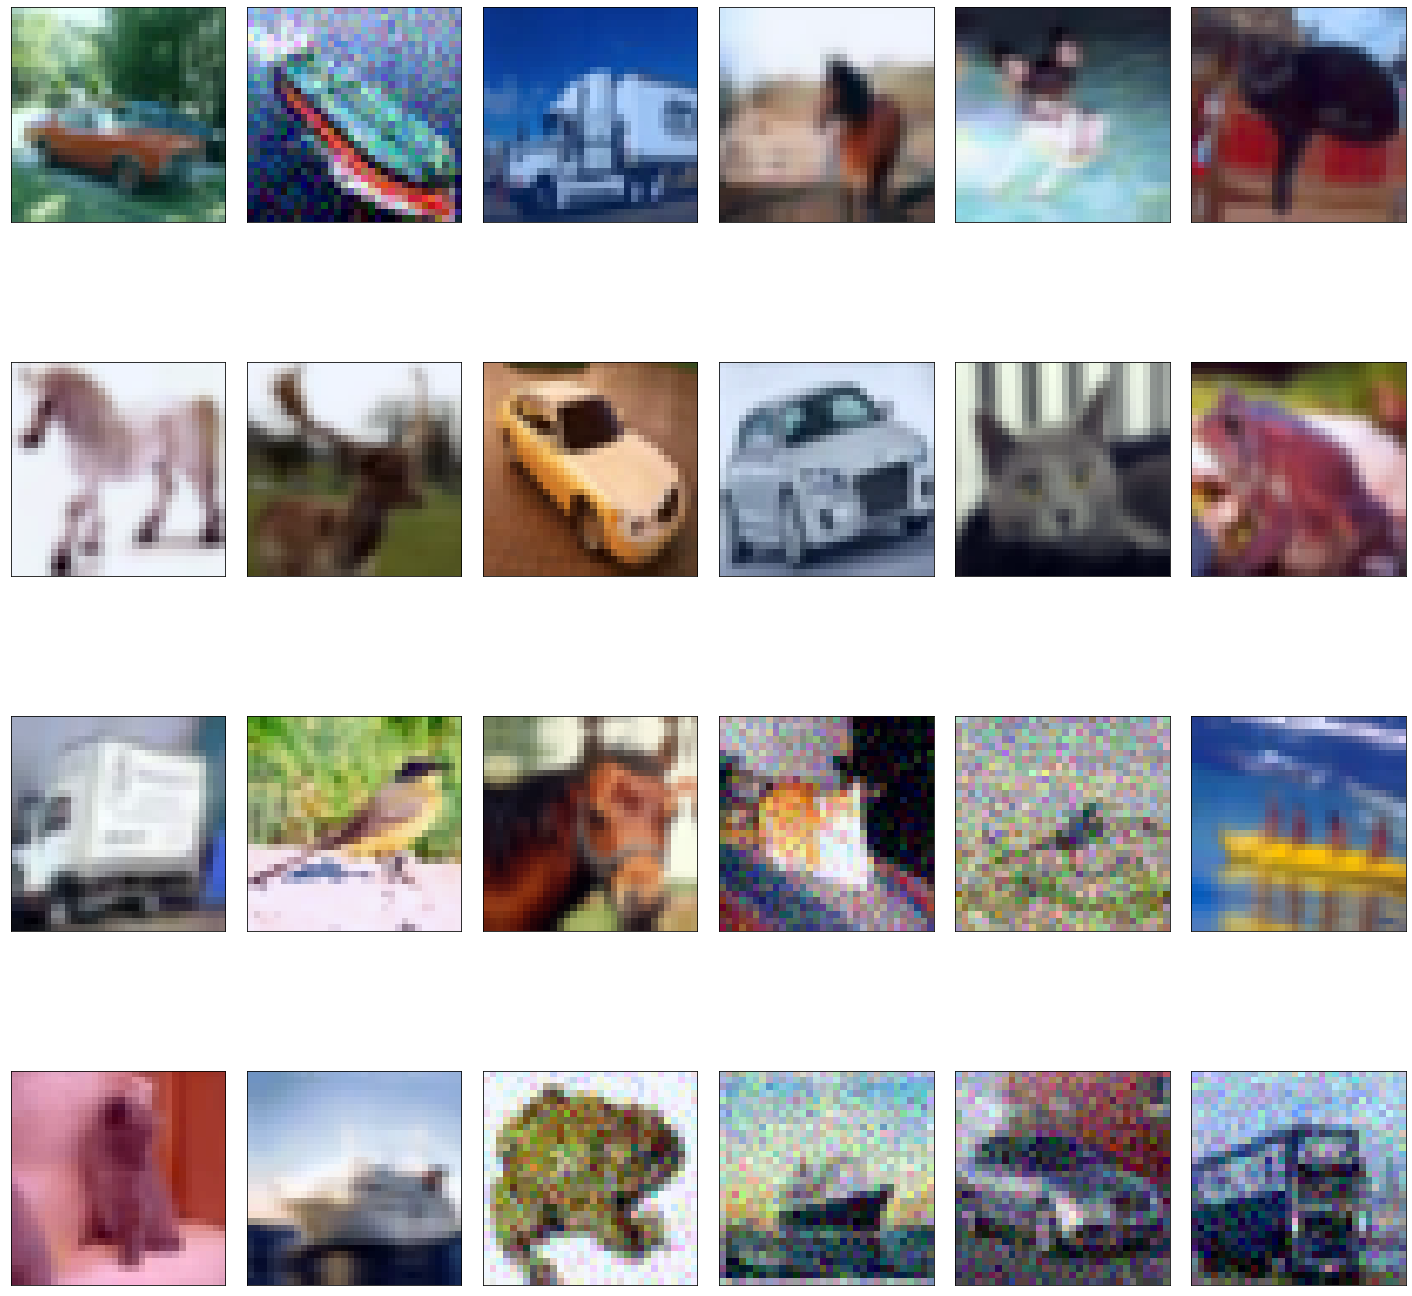

In [22]:
trainBatch = next(iter(trainloader))
images = trainBatch[0][0:24]
plot.tensors_as_images(images, figsize=(25, 25), nrows=4)